In [50]:
from __future__ import division
import time
from scipy.special import logsumexp  #to deal with potential overflow issues
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import csv
from scipy.stats import multivariate_normal as mvn
from scipy.linalg import det 
import scipy
import pdb

from scipy.misc import imresize # to reduce size of images

%matplotlib inline

class_names = ['tshirt/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']


def create_submission_file(fname, preds):
    """
    Create Kaggle submision with predictions written as a csv (comma separated values) file 
    """
    
    ofile  = open(fname, "w")
    writer = csv.writer(ofile, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)        
    writer.writerow(['id', 'label'])
    for i in range(preds.shape[0]):
        writer.writerow([i,preds[i]])
        
def read_fMNIST(dataset = "training", path = "./",dim=16):
    """
    reading in the "Fashion MNIST" data
    this function allows specification of the part to be read (training/testing/validation)
    if load_small = True, this will look for the file(s) associated with the small training set
    Note that if dataset='testing', no labels will be returned
    Dimension: dim specifies the target image dimension (default is to reduce images to 16x16)
    """
    
    #Figure out the name of the file to load    
    if dataset.lower() == "training":
        file_name_suffix = 'Tr'
        has_labels = True
    
    elif dataset.lower() == "validation":
        file_name_suffix = 'Vl'
        has_labels = True

    elif dataset.lower() == "testing":
        file_name_suffix = 'Te'
        has_labels = False

    else:
        print("dataset must be 'testing','validation', or 'training'")
        raise ValueError
    
    #Load the appropriate files
    X = np.load('./x'+file_name_suffix+'.npy')
    if has_labels:
        y = np.load('./y'+file_name_suffix+'.npy')
    
    X = reduceImg(X,dim)
    
    #Return the appropriate data
    if has_labels:
        return X,y
    else:
        return X
         
            
def showImage(image,ax=None):
    """
    Render a given numpy.uint8 2D array of pixel data.
    """
    if len(image.shape) > 1:
        n=image.shape[0]
    else:
        n=int(np.sqrt(image.shape[0]))
        image = image[-n**2:]
        image = image.reshape(n,n)

    
    if ax==None:
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image, cmap=mpl.cm.Greys)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    plt.axis('off')
    

def reduceImg(X,dnew):
    # image size in X is hardcoded = 28 (not best practice!)
    xNew=np.zeros((X.shape[0],dnew*dnew))
    for i in range(X.shape[0]):
        xNew[i]=imresize(X[i].reshape(28,28),(dnew,dnew),'bicubic').flatten()
    return xNew

In [51]:
# Load training data
xTrain, yTrain = read_fMNIST('training')
# Load validation data
xVal, yVal = read_fMNIST('validation')

# scale pixel values to [0,1] to make things better-behaved numerically
xTrain=xTrain/255
xVal=xVal/255

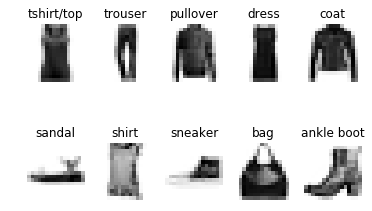

In [52]:
for c in range(10):
    ax=plt.subplot(2,5,c+1)
    ax.clear()
    idx = np.argmax(np.argmax(yTrain,axis=1)==c)
    showImage(xTrain[idx],ax)
    ax.set_title(class_names[c])
    


### Multivariate log PDF

Helper functions below: 

In [53]:
def determinant_rank_cholesky(M, cond=None, rcond=None, lower=True,
        check_finite=True, allow_singular=True):
    
    s, u = scipy.linalg.eigh(M, lower=lower, check_finite=check_finite)
    eps = eigenvals_trans(s, cond, rcond) 

    d = s[s > eps]
    s_pinv =recip(s, eps)
    U = np.multiply(u, np.sqrt(s_pinv))

    return {'rank': len(d), 'U': U, 'log_pdet': np.sum(np.log(d))}

def eigenvals_trans(spectrum, cond=None, rcond=None):
    if rcond is not None:
        cond = rcond
    if cond in [None, -1]:
        t = spectrum.dtype.char.lower()
        factor = {'f': 1E3, 'd': 1E6}
        cond = factor[t] * np.finfo(t).eps
    eps = cond * np.max(abs(spectrum))
    return eps

def recip(v, eps=1e-5):
    return np.array([0 if abs(x) <= eps else 1/x for x in v], dtype=float)


Multivariate Gaussian log PDF: 

In [54]:
def mvn_logpdf(X, mu, cov, diag = False): 
    '''
    X must be a np array, not a np matrix... 
    '''
    cov_inv = np.linalg.inv(cov)
    dets = determinant_rank_cholesky(cov)
    cov_det = dets['log_pdet']
    
    pwrs = []
    for i in range(X.shape[0]):
        x = X[i, :]
        shift = x - mu
        pwr = -1/2* np.sum( np.square( np.dot( shift, dets['U'] ) ), axis = -1)
        pwrs.append( pwr )    

    log_nconst = -1/2 * ( dets['rank'] * np.log(2 * np.pi) + cov_det ) 
    #print("rank: {}\t| cov_det Karl: {}".format(dets['rank'], cov_det))
    #print("pwrs: {}".format(pwrs[0:5]))
    return log_nconst + np.array(pwrs)

Let's test that our log multivariate pdf works: 

In [55]:
#%pdb
n = 2
mean = np.array([1.5] * n); cov = np.identity(n=n)
x = np.array([[0,0], [1,-1], [2,2]])
y_actual = mvn.logpdf(x, mean = mean, cov = cov); 
print(y_actual)
y = mvn_logpdf(x, mean, cov)
print(y)
print(y_actual / y)

[-4.08787707 -5.08787707 -2.08787707]
[-4.08787707 -5.08787707 -2.08787707]
[ 1.  1.  1.]


In [56]:
class GaussianMixtureModel(object):
    """Gaussian Mixture Model"""
    
    def __init__(self, X, num_comp, max_iter=50, eps=10**(-7), cov_type='diag'):
        """Initialize the GMM model.
        num_feat: Feature dimension of our data
        num_comp: Number of components to fit in the mixture model.
        max_iter: Maximum number of EM iterations.
        cov_type: Type of covariance matrix used by multivariate Gaussian models ('diag': diagonal, otherwise full)
        """
        self.nf = X.shape[1]
        self.nc = num_comp
        self.max_iter = max_iter
        self.eps = 0.00001
        self.cov_type = cov_type
        
        # Initialization: feel free to improve this.
        # Note that we are passing the data X so you can use it to try smarter init strategies
        
        # initialize mixing prob to be uniform
        self.pi = np.repeat(1.0/self.nc, self.nc)
        # initialize means to random (Gaussian) vectors

        self.mu=np.random.uniform(0,1,((self.nc,self.nf)))  #np.zeros((self.nc,self.nf)) 
        self.sigma=np.zeros((self.nc,self.nf,self.nf))
        # initialize covariances to I_nf (identity)
        for c in range(self.nc):
            self.sigma[c]=np.eye(self.nf)
    
        
    def Estep(self, X):
        """Update the soft weights and calculate likelihood in the process."""
        log_gamma = np.zeros((X.shape[0], self.nc))
        log_pi = np.log(self.pi)
        for comp in range(self.nc): #calculate weighted density for each component
            
            # put here code you need to compute log_gamma as explained below; everything else will follow
            
            # this is the unnormalized value of responsibilities, i.e., log ( pi_c*p(x|c) )
            p_c_old = mvn_logpdf(X, self.mu[comp, :], self.sigma[comp] )
            
           
            #eigs = np.linalg.eigvals(self.sigma[comp])
            #print(np.prod(eigs))
            
            log_gamma[:, comp] = np.log(self.pi[comp]) + p_c_old
            
        
        # now you can use the values of log_gamma to calculate log-likelihood, responsibilities, etc
        log_prob_per_instance = logsumexp(log_gamma, axis=1, keepdims=True)
        log_likelihood = np.mean(log_prob_per_instance)
        gamma = np.exp(log_gamma - log_prob_per_instance)  # note that this will compute actual responsibilities
        return gamma, log_likelihood, log_prob_per_instance
        
        
    def Mstep(self, X, gamma):
        """Update the model params given the soft weights."""
        # Calculate unnormalized pi with epsilon added to avoid cases where a component gets no instances
        unnorm_pi = np.sum(gamma, axis=0) # shape = (nc,);
        # Update the overall soft assignments to different components
        self.pi = unnorm_pi/np.sum(unnorm_pi)
        
        for comp in range(self.nc): # update parameters for each component
            # Scale the different instances by the soft weight for the current component
            resp_data = np.dot(np.diag(gamma[:, comp]), X)
            # Normalize the responsible data by total soft weight to get mean
            self.mu[comp] = np.sum(resp_data, axis=0)/unnorm_pi[comp]
            
            shift_data = X - self.mu[comp]   # x - mu
            # Captures the multiplication of gamma in covariance calculation
            resp_scaled_shift_data = np.dot(np.diag(gamma[:, comp]), shift_data)
            
            if self.cov_type == 'diag':
                # Assume that the covariance matrices are diagonal for ease of computation
                # gamma_ik * (x_ij - mu_kj)**2 / sum_i gamma_ik   
                # remember to guard against collapse (sigmas too close to zero)
                
                #add code to compute self.sigma[comp]
                ss = resp_scaled_shift_data * shift_data 
                weighted_vars = np.sum(ss, axis = 0)/ unnorm_pi[comp]
                regulated_vars = np.maximum(self.eps, weighted_vars)
                self.sigma[comp] = np.diag(regulated_vars)
                
                
            else:
                # Do the full rank covariance matrix calculation 
                # here, too, you need to consider some protection against collapsing covariance matrices   
        
                #add code to compute self.sigma[comp]
                
                cov_matrix = np.dot(np.transpose(shift_data), resp_scaled_shift_data) / unnorm_pi[comp]
                
                #reg_vals = np.maximum(self.eps, np.real(vals))
                #reg_cov_matrix = np.dot( np.dot(Q, np.diag(reg_vals) ), np.transpose(Q) )
                reg_cov_matrix = cov_matrix + np.diag([self.eps] * cov_matrix.shape[0])
                self.sigma[comp] = reg_cov_matrix
                
    
    def train(self, X,verbose='final'):
        """Train the model using EM."""
        prev_likelihood = -np.inf  # Keep track of previous log likelihood
        gamma, log_likelihood, _ = self.Estep(X)  
        for i in range(self.max_iter):
            self.Mstep(X, gamma)  # M-step
            gamma, log_likelihood, _ = self.Estep(X)  
            if np.isclose(log_likelihood,prev_likelihood):
                # Convergence = no significant increase in likelihood after an iteration.
                # Feel free to try other stopping criteria
                break
            else:
                prev_likelihood = log_likelihood
            if verbose == 'iter':
                print ("   Iteration: %d, log-likelihood: %.4f" %(i, log_likelihood))
            
        if verbose == 'final':
                print ("Iteration %d (final), log-likelihood: %.4f" %(i, log_likelihood))
                
                
    def trainFast(self,X,verbose='final',rs=[.03,.1,.3,1]):
        """
        Train the model using EM, gradually fitting larger portion of the data
        rs specifies the fractions of the full data set size to use
        Note: by making the last elements of rs less than 1 you can effectively train on a subset of data
        (examples past the first r*X.shape[0] won't be seen at all)
        """
        for r in rs:
            self.train(X[0:int(np.floor(X.shape[0]*r))],verbose='final')
        

In [57]:
# organize data by class
classData=dict()
for y in range(10):
    classData[y]=xTrain[np.argmax(yTrain,axis=1)==y]


In [58]:
def get_accuracy(models, X,y):
    """
    Compute accuracy of the GMM generative model on (X,y).
    model[c] is the GMM for class c
    Returns (acc, yhat) where yhat are the predictions (in label form)
    """
    total_data = 0.0
    correct = 0.0
    C = len(models)
    N = X.shape[0]
    logLik = np.zeros((N,C))
    for c in range(C):
        _,_, ll_class = models[c].Estep(X)
        logLik[:,c] = np.squeeze(ll_class)
    yhat = np.argmax(logLik,axis=1)
    acc = np.mean(yhat==np.argmax(y,axis=1))
    return acc, yhat


In [59]:
def showMeans(gmmModels,c,handles=False):
    """
    Display means for Gaussian components of gmmModels for class c
    """
    k = mmodels[c].nc
    fig,axes = plt.subplots(1,k)
    
    for j in range(k):
        if k==1:
            ax=axes
        else:
            ax=axes[j]
        showImage(gmmModels[c].mu[j],ax)
        ax.axis('off')
        if j==0:
            ax.set_title(class_names[c]+'/'+str(j))
        else:
            ax.set_title('/'+str(j))
    if handles:
        return fig,axes

Iteration 11 (final), log-likelihood: 346.2610
Iteration 8 (final), log-likelihood: 342.1424
Iteration 10 (final), log-likelihood: 348.1359
================ class 0(tshirt/top), mixture of 3 diag Gaussians
Iteration 16 (final), log-likelihood: 660.1385
Iteration 5 (final), log-likelihood: 657.7709
Iteration 20 (final), log-likelihood: 661.9963
================ class 1(trouser), mixture of 3 diag Gaussians
Iteration 9 (final), log-likelihood: 282.8650
Iteration 22 (final), log-likelihood: 282.6836
Iteration 6 (final), log-likelihood: 277.9265
================ class 2(pullover), mixture of 3 diag Gaussians
Iteration 20 (final), log-likelihood: 501.3228
Iteration 9 (final), log-likelihood: 498.7692
Iteration 9 (final), log-likelihood: 496.8138
================ class 3(dress), mixture of 3 diag Gaussians
Iteration 9 (final), log-likelihood: 331.6748
Iteration 10 (final), log-likelihood: 333.9861
Iteration 19 (final), log-likelihood: 331.0283
================ class 4(coat), mixture of 3 dia

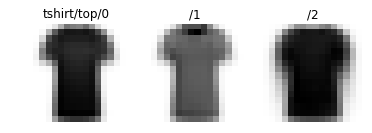

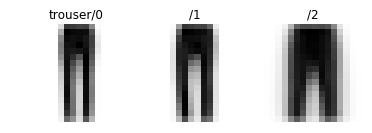

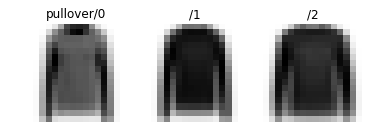

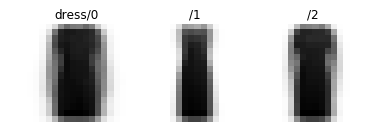

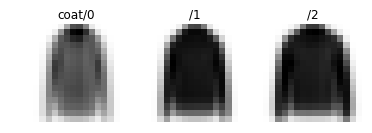

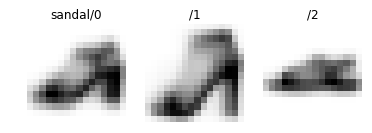

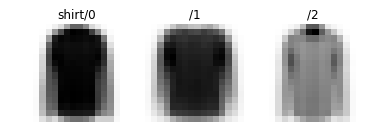

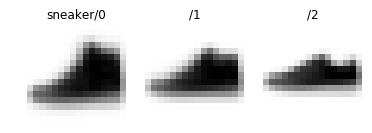

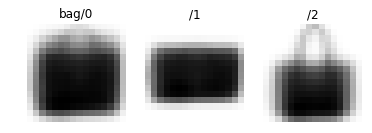

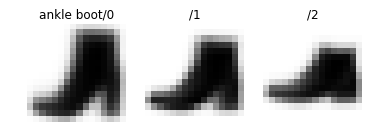

Iteration 19 (final), log-likelihood: 412.2387
Iteration 19 (final), log-likelihood: 412.5829
Iteration 18 (final), log-likelihood: 415.5256
================ class 0(tshirt/top), mixture of 12 diag Gaussians
Iteration 10 (final), log-likelihood: 685.3684
Iteration 12 (final), log-likelihood: 680.4295
Iteration 34 (final), log-likelihood: 687.9735
================ class 1(trouser), mixture of 12 diag Gaussians
Iteration 15 (final), log-likelihood: 339.5010
Iteration 10 (final), log-likelihood: 327.1151
Iteration 27 (final), log-likelihood: 339.4959
================ class 2(pullover), mixture of 12 diag Gaussians
Iteration 21 (final), log-likelihood: 565.8179
Iteration 13 (final), log-likelihood: 567.3579
Iteration 39 (final), log-likelihood: 579.8404
================ class 3(dress), mixture of 12 diag Gaussians
Iteration 29 (final), log-likelihood: 406.0832
Iteration 27 (final), log-likelihood: 418.7838
Iteration 27 (final), log-likelihood: 418.9613
================ class 4(coat), mixtu

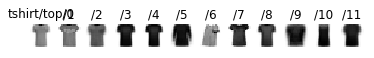

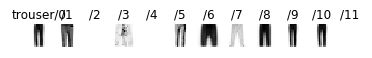

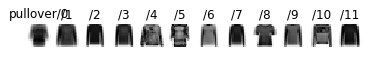

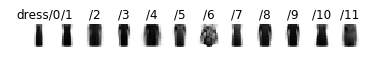

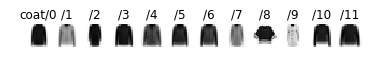

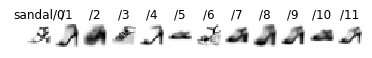

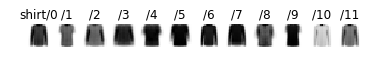

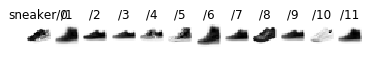

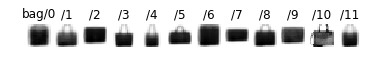

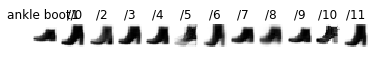

In [26]:
ks=[3,12]
gmmacc=dict()
gmmaccTrain=dict()

#%pdb
for k in ks:
    mmodels=dict()
    
    for y in range(10):
        mmodels[y] = GaussianMixtureModel(classData[y], k, max_iter=40, cov_type='diag')
        mmodels[y].trainFast(classData[y],verbose='final',rs=[.1,.25,1])
        print('================ class '+str(y)+'('+class_names[y]+'), mixture of %d diag Gaussians'%k)
        
    gmmacc[k], _ = get_accuracy(mmodels,xVal,yVal)
    gmmaccTrain[k], _ = get_accuracy(mmodels,xTrain,yTrain)
    print('GMM-diag (%d) accuracy:  %.4f  [ %.4f on train]'%(k,gmmacc[k],gmmaccTrain[k]))
    for y in range(10):
        showMeans(mmodels,y)
        plt.show()

Iteration 3 (final), log-likelihood: 900.3623
Iteration 1 (final), log-likelihood: 565.8904
Iteration 1 (final), log-likelihood: 470.4748
================ class 0(tshirt/top), mixture of 3 full Gaussians
Iteration 4 (final), log-likelihood: 962.5731
Iteration 1 (final), log-likelihood: 829.9953
Iteration 2 (final), log-likelihood: 773.0723
================ class 1(trouser), mixture of 3 full Gaussians
Iteration 4 (final), log-likelihood: 915.3207
Iteration 7 (final), log-likelihood: 606.7480
Iteration 8 (final), log-likelihood: 546.6442
================ class 2(pullover), mixture of 3 full Gaussians
Iteration 4 (final), log-likelihood: 911.0543
Iteration 3 (final), log-likelihood: 645.3420
Iteration 25 (final), log-likelihood: 589.8981
================ class 3(dress), mixture of 3 full Gaussians
Iteration 3 (final), log-likelihood: 904.9809
Iteration 3 (final), log-likelihood: 608.6411
Iteration 29 (final), log-likelihood: 577.6168
================ class 4(coat), mixture of 3 full Gaus

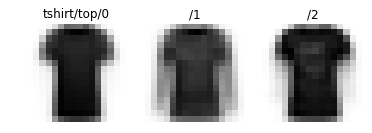

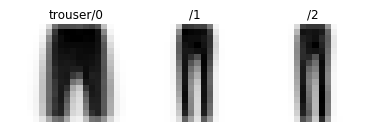

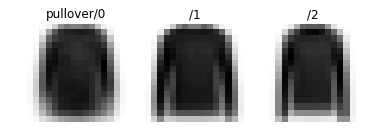

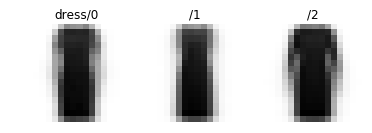

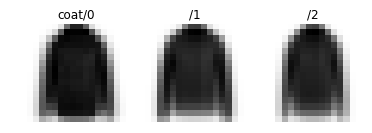

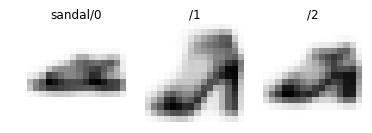

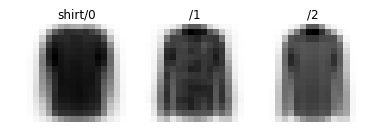

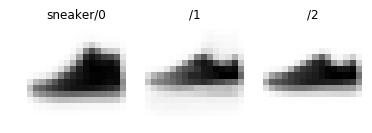

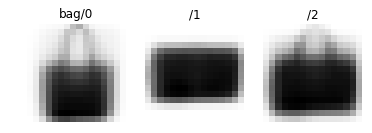

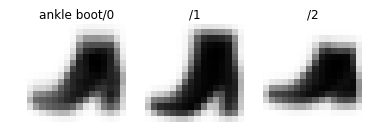

Iteration 4 (final), log-likelihood: 1103.6758
Iteration 1 (final), log-likelihood: 711.8374
Iteration 1 (final), log-likelihood: 513.7637
================ class 0(tshirt/top), mixture of 12 full Gaussians
Iteration 4 (final), log-likelihood: 1093.5080
Iteration 1 (final), log-likelihood: 887.8595
Iteration 15 (final), log-likelihood: 840.5277
================ class 1(trouser), mixture of 12 full Gaussians
Iteration 4 (final), log-likelihood: 1077.4772
Iteration 1 (final), log-likelihood: 631.8909
Iteration 1 (final), log-likelihood: 508.0772
================ class 2(pullover), mixture of 12 full Gaussians
Iteration 4 (final), log-likelihood: 1116.4460
Iteration 7 (final), log-likelihood: 779.0660
Iteration 22 (final), log-likelihood: 694.9948
================ class 3(dress), mixture of 12 full Gaussians
Iteration 4 (final), log-likelihood: 1073.6707
Iteration 2 (final), log-likelihood: 669.9398
Iteration 1 (final), log-likelihood: 545.1016
================ class 4(coat), mixture of 12

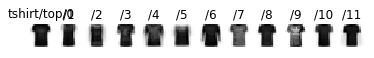

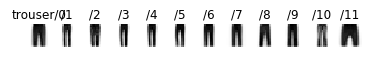

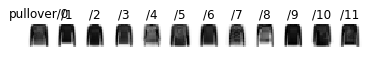

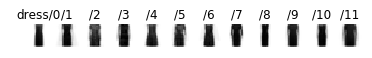

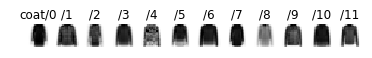

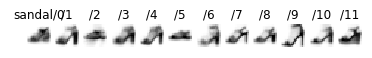

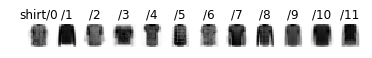

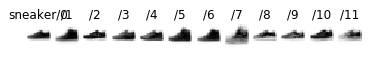

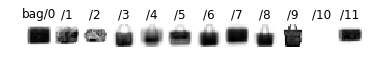

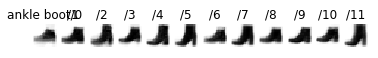

In [23]:
ks=[3,12]
gmmacc=dict()
gmmaccTrain=dict()

#%pdb
for k in ks:
    mmodels=dict()
    
    for y in range(10):
        mmodels[y] = GaussianMixtureModel(classData[y], k, max_iter=30, cov_type='full')
        mmodels[y].trainFast(classData[y],verbose='final',rs=[.05,.25,1])
        print('================ class '+str(y)+'('+class_names[y]+'), mixture of %d full Gaussians'%k)
        
    gmmacc[k], _ = get_accuracy(mmodels,xVal,yVal)
    gmmaccTrain[k], _ = get_accuracy(mmodels,xTrain,yTrain)
    print('GMM-full (%d) accuracy:  %.4f  [ %.4f on train]'%(k,gmmacc[k],gmmaccTrain[k]))
    for y in range(10):
        showMeans(mmodels,y)
        plt.show()

## 2.2) QDA 

Iteration 1 (final), log-likelihood: 620.8047
Iteration 1 (final), log-likelihood: 473.1816
Iteration 1 (final), log-likelihood: 443.6280
================ class 0(tshirt/top), mixture of 1 full Gaussians
Iteration 1 (final), log-likelihood: 842.6309
Iteration 1 (final), log-likelihood: 756.5585
Iteration 1 (final), log-likelihood: 703.9348
================ class 1(trouser), mixture of 1 full Gaussians
Iteration 1 (final), log-likelihood: 637.4554
Iteration 1 (final), log-likelihood: 509.1522
Iteration 1 (final), log-likelihood: 477.3404
================ class 2(pullover), mixture of 1 full Gaussians
Iteration 1 (final), log-likelihood: 671.5879
Iteration 1 (final), log-likelihood: 570.0892
Iteration 1 (final), log-likelihood: 539.9084
================ class 3(dress), mixture of 1 full Gaussians
Iteration 1 (final), log-likelihood: 629.3900
Iteration 1 (final), log-likelihood: 542.1496
Iteration 1 (final), log-likelihood: 511.9470
================ class 4(coat), mixture of 1 full Gaussi

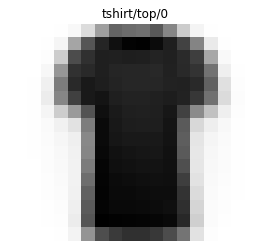

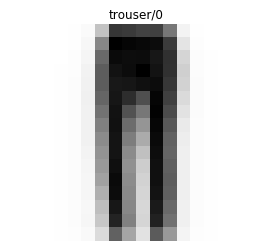

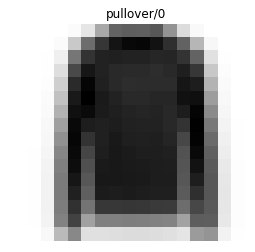

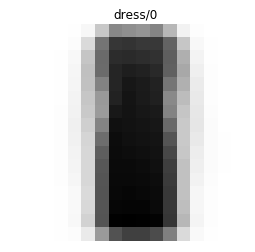

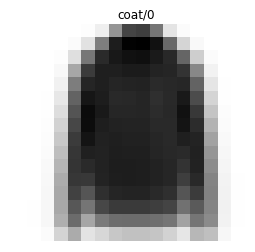

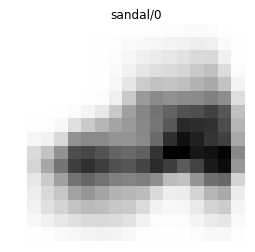

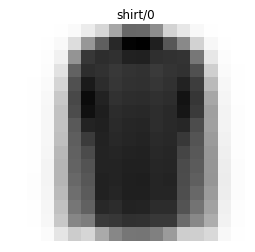

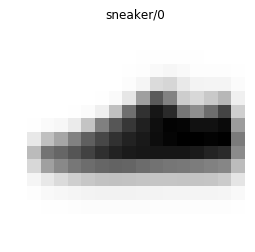

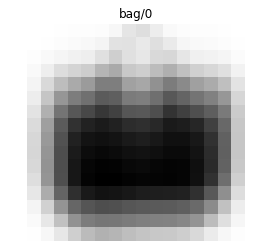

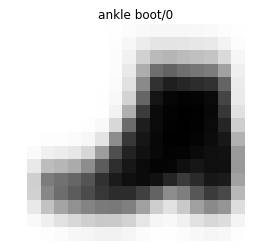

In [46]:
ks=[1]
gmmacc=dict()
gmmaccTrain=dict()

#%pdb
for k in ks:
    mmodels=dict()
    
    for y in range(10):
        mmodels[y] = GaussianMixtureModel(classData[y], k, max_iter=30, cov_type='full')
        mmodels[y].trainFast(classData[y],verbose='final',rs=[.05,.25,1])
        print('================ class '+str(y)+'('+class_names[y]+'), mixture of %d full Gaussians'%k)
        
    gmmacc[k], _ = get_accuracy(mmodels,xVal,yVal)
    gmmaccTrain[k], _ = get_accuracy(mmodels,xTrain,yTrain)
    print('GMM-full (%d) accuracy:  %.4f  [ %.4f on train]'%(k,gmmacc[k],gmmaccTrain[k]))
    for y in range(10):
        showMeans(mmodels,y)
        plt.show()

## Naive Bayes 

Iteration 0 (final), log-likelihood: 133.5490
================ class 0(tshirt/top), mixture of 1 full Gaussians
Iteration 0 (final), log-likelihood: 319.5436
================ class 1(trouser), mixture of 1 full Gaussians
Iteration 0 (final), log-likelihood: 131.8422
================ class 2(pullover), mixture of 1 full Gaussians
Iteration 0 (final), log-likelihood: 275.2276
================ class 3(dress), mixture of 1 full Gaussians
Iteration 0 (final), log-likelihood: 204.6846
================ class 4(coat), mixture of 1 full Gaussians
Iteration 0 (final), log-likelihood: 217.9530
================ class 5(sandal), mixture of 1 full Gaussians
Iteration 0 (final), log-likelihood: 93.5847
================ class 6(shirt), mixture of 1 full Gaussians
Iteration 0 (final), log-likelihood: 423.5624
================ class 7(sneaker), mixture of 1 full Gaussians
Iteration 0 (final), log-likelihood: 29.4092
================ class 8(bag), mixture of 1 full Gaussians
Iteration 0 (final), log-like

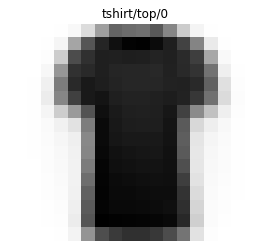

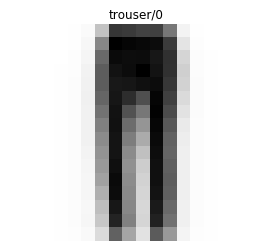

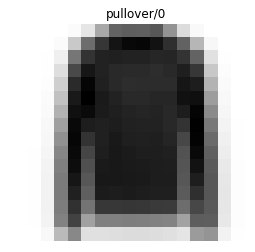

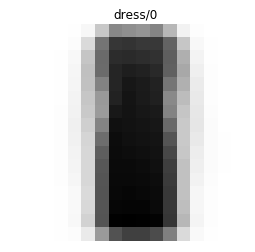

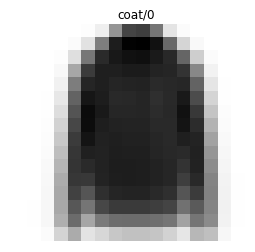

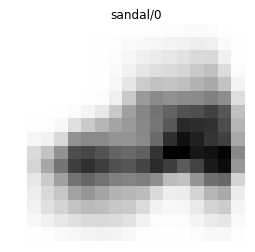

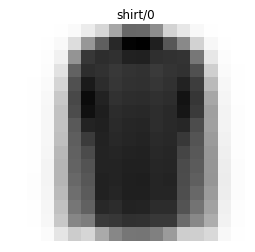

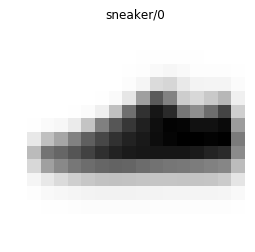

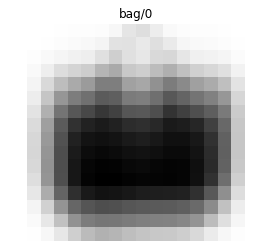

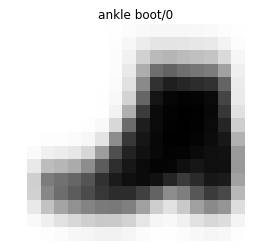

In [65]:
ks=[1]
gmmacc=dict()
gmmaccTrain=dict()

#%pdb
for k in ks:
    mmodels=dict()
    
    for y in range(10):
        mmodels[y] = GaussianMixtureModel(classData[y], k, max_iter=1, cov_type='diag')
        mmodels[y].trainFast(classData[y],verbose='final',rs=[1])
        print('================ class '+str(y)+'('+class_names[y]+'), mixture of %d full Gaussians'%k)
        
    gmmacc[k], _ = get_accuracy(mmodels,xVal,yVal)
    gmmaccTrain[k], _ = get_accuracy(mmodels,xTrain,yTrain)
    print('GMM-full (%d) accuracy:  %.4f  [ %.4f on train]'%(k,gmmacc[k],gmmaccTrain[k]))
    for y in range(10):
        showMeans(mmodels,y)
        plt.show()

Things to do:
- fill in the code to run the training above
- use the code to also run QDA and Naive Bayes experiments
- decide on any improvements/extensions, and try them out
- settle on the best overall generative model, and compute and save test prediction (below)

## Experimentation 

For the case k = 3 and k = 12 components, we have seen that the diagonal (independence) assumption is faster, but performs worse in validation. 12 components works better than 3, and we only hit the max iteration of 30 twice - usually just hit a wall in terms of log lik gain. 

Based off of this, let's just experiment with k = 8 (somewhere in between) and k = 15 (in case the validation performance does do better for larger values of k. 

Iteration 4 (final), log-likelihood: 1062.2712
Iteration 3 (final), log-likelihood: 675.9397
Iteration 4 (final), log-likelihood: 530.0806
================ class 0(tshirt/top), mixture of 8 full Gaussians
Iteration 5 (final), log-likelihood: 1084.3696
Iteration 5 (final), log-likelihood: 876.7874
Iteration 29 (final), log-likelihood: 843.8573
================ class 1(trouser), mixture of 8 full Gaussians
Iteration 3 (final), log-likelihood: 1061.0429
Iteration 15 (final), log-likelihood: 665.0500
Iteration 13 (final), log-likelihood: 579.6311
================ class 2(pullover), mixture of 8 full Gaussians
Iteration 4 (final), log-likelihood: 1067.1498
Iteration 3 (final), log-likelihood: 741.5033
Iteration 1 (final), log-likelihood: 595.3900
================ class 3(dress), mixture of 8 full Gaussians
Iteration 4 (final), log-likelihood: 1067.7390
Iteration 1 (final), log-likelihood: 678.5744
Iteration 11 (final), log-likelihood: 596.6738
================ class 4(coat), mixture of 8 fu

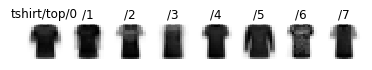

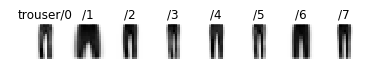

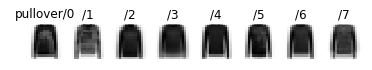

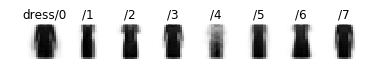

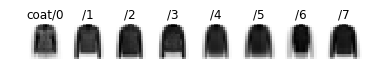

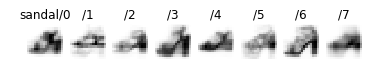

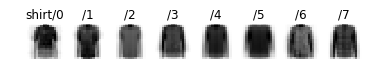

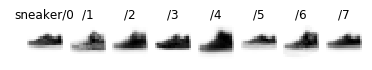

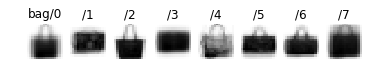

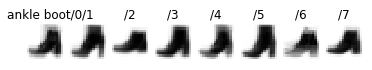

Iteration 4 (final), log-likelihood: 1100.7327
Iteration 2 (final), log-likelihood: 680.9633
Iteration 20 (final), log-likelihood: 542.3412
================ class 0(tshirt/top), mixture of 15 full Gaussians
Iteration 5 (final), log-likelihood: 1116.2899
Iteration 10 (final), log-likelihood: 904.7844
Iteration 10 (final), log-likelihood: 836.3194
================ class 1(trouser), mixture of 15 full Gaussians
Iteration 3 (final), log-likelihood: 1080.9072
Iteration 1 (final), log-likelihood: 648.4003
Iteration 15 (final), log-likelihood: 580.1482
================ class 2(pullover), mixture of 15 full Gaussians
Iteration 4 (final), log-likelihood: 1123.7580
Iteration 10 (final), log-likelihood: 814.4530
Iteration 18 (final), log-likelihood: 699.0584
================ class 3(dress), mixture of 15 full Gaussians
Iteration 3 (final), log-likelihood: 1124.8617
Iteration 1 (final), log-likelihood: 756.9046
Iteration 2 (final), log-likelihood: 565.5888
================ class 4(coat), mixture o

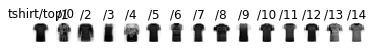

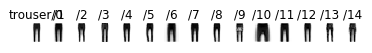

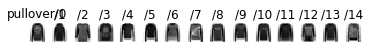

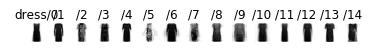

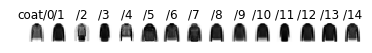

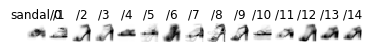

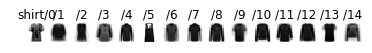

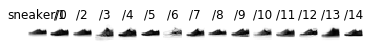

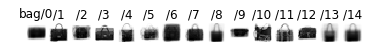

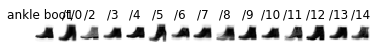

In [81]:
ks=[8, 15]
mmodels_list = []
gmmacc=dict()
gmmaccTrain=dict()

#%pdb
for k in ks:
    mmodels=dict()
    
    for y in range(10):
        mmodels[y] = GaussianMixtureModel(classData[y], k, max_iter=30, cov_type='full')
        mmodels[y].trainFast(classData[y],verbose='final',rs=[.05,.25,1])
        print('================ class '+str(y)+'('+class_names[y]+'), mixture of %d full Gaussians'%k)
        
    gmmacc[k], _ = get_accuracy(mmodels,xVal,yVal)
    gmmaccTrain[k], _ = get_accuracy(mmodels,xTrain,yTrain)
    print('GMM-full (%d) accuracy:  %.4f  [ %.4f on train]'%(k,gmmacc[k],gmmaccTrain[k]))
    mmodels_list.append(mmodels)
    for y in range(10):
        showMeans(mmodels,y)
        plt.show()

Well, that didn't work out too well. k = 15 begins to overfit and k = 7 is underfitting. We can conjecture then, the best val performance could be within 7 - 12. I'm going to retrain the k = 12 case and throw in k = 10. 

Iteration 3 (final), log-likelihood: 1036.0479
Iteration 20 (final), log-likelihood: 648.0576
Iteration 16 (final), log-likelihood: 575.6049
================ class 0(tshirt/top), mixture of 10 full Gaussians
Iteration 3 (final), log-likelihood: 1072.2866
Iteration 1 (final), log-likelihood: 858.6918
Iteration 1 (final), log-likelihood: 747.3183
================ class 1(trouser), mixture of 10 full Gaussians
Iteration 4 (final), log-likelihood: 1069.7191
Iteration 7 (final), log-likelihood: 666.0256
Iteration 29 (final), log-likelihood: 590.2149
================ class 2(pullover), mixture of 10 full Gaussians
Iteration 4 (final), log-likelihood: 1068.5219
Iteration 2 (final), log-likelihood: 750.9783
Iteration 3 (final), log-likelihood: 614.6964
================ class 3(dress), mixture of 10 full Gaussians
Iteration 4 (final), log-likelihood: 1094.6011
Iteration 2 (final), log-likelihood: 721.0860
Iteration 21 (final), log-likelihood: 611.3408
================ class 4(coat), mixture of 

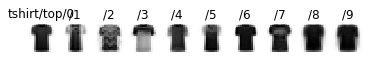

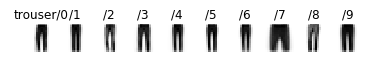

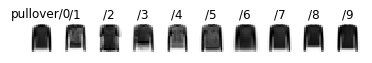

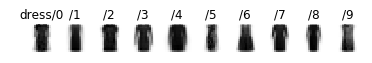

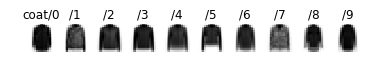

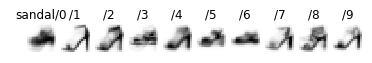

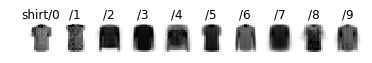

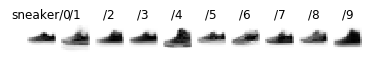

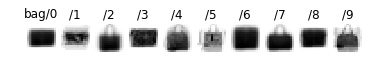

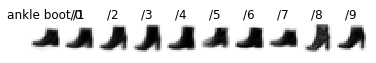

Iteration 4 (final), log-likelihood: 1093.5328
Iteration 10 (final), log-likelihood: 689.2127
Iteration 19 (final), log-likelihood: 586.4410
================ class 0(tshirt/top), mixture of 12 full Gaussians
Iteration 4 (final), log-likelihood: 1097.3198
Iteration 1 (final), log-likelihood: 871.0547
Iteration 1 (final), log-likelihood: 756.5829
================ class 1(trouser), mixture of 12 full Gaussians
Iteration 4 (final), log-likelihood: 1100.6722
Iteration 2 (final), log-likelihood: 697.7669
Iteration 25 (final), log-likelihood: 594.6548
================ class 2(pullover), mixture of 12 full Gaussians
Iteration 4 (final), log-likelihood: 1088.7130
Iteration 13 (final), log-likelihood: 750.8617
Iteration 12 (final), log-likelihood: 666.4680
================ class 3(dress), mixture of 12 full Gaussians
Iteration 4 (final), log-likelihood: 1092.8784
Iteration 6 (final), log-likelihood: 707.4969
Iteration 16 (final), log-likelihood: 605.6629
================ class 4(coat), mixture o

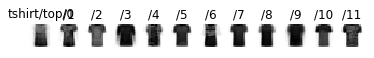

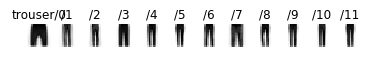

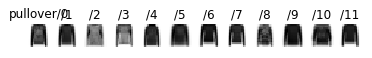

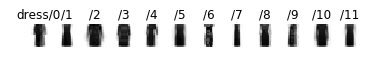

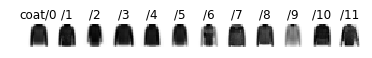

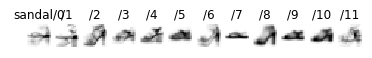

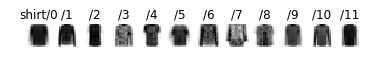

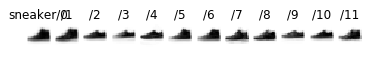

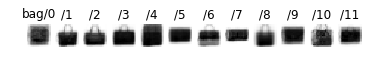

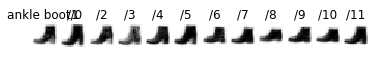

In [84]:
ks=[10, 12]
mmodels_list = []
gmmacc=dict()
gmmaccTrain=dict()

#%pdb
for k in ks:
    mmodels=dict()
    
    for y in range(10):
        mmodels[y] = GaussianMixtureModel(classData[y], k, max_iter=30, cov_type='full')
        mmodels[y].trainFast(classData[y],verbose='final',rs=[.05,.25,1])
        print('================ class '+str(y)+'('+class_names[y]+'), mixture of %d full Gaussians'%k)
        
    gmmacc[k], _ = get_accuracy(mmodels,xVal,yVal)
    gmmaccTrain[k], _ = get_accuracy(mmodels,xTrain,yTrain)
    print('GMM-full (%d) accuracy:  %.4f  [ %.4f on train]'%(k,gmmacc[k],gmmaccTrain[k]))
    mmodels_list.append(mmodels)
    for y in range(10):
        showMeans(mmodels,y)
        plt.show()

In [85]:
import pandas as pd 
pd.to_pickle(mmodels_list, "mmodels_10_12.pkl")

Great! The k = 10 outperforms k = 12. Let's use that as our best model. 

In [70]:
def get_predictions(models, X): 
    C = len(models)
    N = X.shape[0]
    logLik = np.zeros((N,C))
    for c in range(C):
        _,_, ll_class = models[c].Estep(X)
        logLik[:,c] = np.squeeze(ll_class)
    yhat = np.argmax(logLik,axis=1)
    return yhat

In [90]:
xTe = read_fMNIST('testing') / 255
bestmodel = pd.read_pickle("mmodels_10_12.pkl")[0]
#xTe = preprocess_data(xTe,mu,sigma,visualize=False)
preds = get_predictions(bestmodel, xTe)
create_submission_file("kaggle-submission.csv", preds)